In [2]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [61]:
#CUSTOM_MODEL_NAME = 'eiland_detector_popp_map'
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
#PRETRAINED_MODEL_NAME = 'ssd_resnet50_v1_fpn_1024x1024_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
#PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_1024x1024_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
CUSTOM_MODEL_NAME = 'eiland_detector'

MAP_LAYER_NAME = "popp_karte"

paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'APIMODEL_PATH': os.path.join('Tensorflow', 'models'),
    'ANNOTATION_PATH': os.path.join('map_layers', MAP_LAYER_NAME, 'annotations'),
    'MAP_LAYER_PATH': os.path.join('map_layers', MAP_LAYER_NAME),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace', 'models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace', 'pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('map_layers', MAP_LAYER_NAME, "models"),
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace', 'models', CUSTOM_MODEL_NAME, 'export'),
    'TFJS_PATH': os.path.join('Tensorflow', 'workspace', 'models', CUSTOM_MODEL_NAME, 'tfjsexport'),
    'TFLITE_PATH': os.path.join('Tensorflow', 'workspace', 'models', CUSTOM_MODEL_NAME, 'tfliteexport'),
    'PROTOC_PATH': os.path.join('Tensorflow', 'protoc')
}


files = {
    'PIPELINE_CONFIG': os.path.join('map_layers', MAP_LAYER_NAME, "models", 'pipeline.config'),
    'LABELMAP': os.path.join('map_layers', MAP_LAYER_NAME, "label_map.pbtxt")
}

In [62]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-3')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

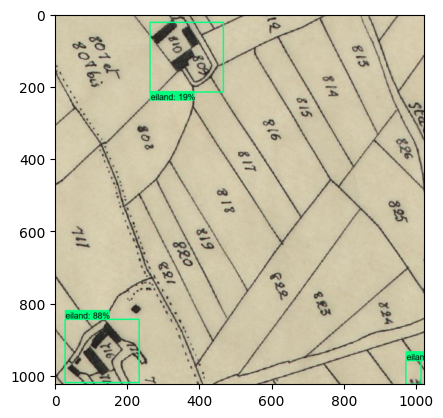

In [70]:
IMAGE_PATH = r"C:\Users\jaddh\code_projects\EILearn\map_layers\popp_karte\images\train\16_33247_21942.jpg"
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=200,
            min_score_thresh=0.1,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [107]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

tiles_folder = r"C:\Users\jaddh\code_projects\EILearn\Tensorflow\workspace\images\tiles\Poppe Kaarte\16"
processsed_folder = r"C:\Users\jaddh\code_projects\EILearn\Tensorflow\workspace\images\processed_tiles\Poppe Kaarte\16"

# for each folder inside tiles_folder
for folder in os.listdir(tiles_folder):
    # if it is not a folder, skip it
    if os.path.isdir(os.path.join(tiles_folder,folder)):  
        print(folder)
        # if the folder in the processed folder doesnt exist, create it
        if not os.path.exists(os.path.join(processsed_folder, folder)):
            os.makedirs(os.path.join(processsed_folder, folder))
        
        # for each image in the folder
        for image in os.listdir(os.path.join(tiles_folder,folder)):
            if image.endswith(".png"):
                print(img)
                # read the image
                
                img = cv2.imread(os.path.join(tiles_folder,folder,image))
                image_np = np.array(img)
                
                input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
                detections = detect_fn(input_tensor)

                num_detections = int(detections.pop('num_detections'))
                detections = {key: value[0, :num_detections].numpy()
                            for key, value in detections.items()}
                detections['num_detections'] = num_detections

                # detection_classes should be ints.
                detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

                label_id_offset = 1
                image_np_with_detections = image_np.copy()

                viz_utils.visualize_boxes_and_labels_on_image_array(
                            image_np_with_detections,
                            detections['detection_boxes'],
                            detections['detection_classes']+label_id_offset,
                            detections['detection_scores'],
                            category_index,
                            use_normalized_coordinates=True,
                            max_boxes_to_draw=100,
                            min_score_thresh=.6,
                            agnostic_mode=False)

                # save the image
                cv2.imwrite(os.path.join(processsed_folder,folder,image), image_np_with_detections)
    



33258
[[[170 211 226]
  [170 211 226]
  [167 210 225]
  ...
  [201 205 206]
  [201 205 206]
  [202 206 207]]

 [[171 212 227]
  [171 212 227]
  [168 211 226]
  ...
  [200 204 205]
  [200 204 205]
  [201 205 206]]

 [[171 212 227]
  [171 212 227]
  [169 212 227]
  ...
  [198 202 203]
  [198 202 203]
  [198 202 203]]

 ...

 [[143 185 208]
  [143 185 208]
  [140 184 207]
  ...
  [142 185 206]
  [142 185 206]
  [142 185 206]]

 [[142 184 207]
  [142 184 207]
  [141 185 208]
  ...
  [142 185 206]
  [142 185 206]
  [142 185 206]]

 [[142 184 207]
  [142 184 207]
  [141 185 208]
  ...
  [142 185 206]
  [142 185 206]
  [142 185 206]]]
[[[163 206 221]
  [163 206 221]
  [165 208 223]
  ...
  [179 216 230]
  [180 217 231]
  [181 218 232]]

 [[163 206 221]
  [163 206 221]
  [165 208 223]
  ...
  [178 215 229]
  [179 216 230]
  [181 218 232]]

 [[164 207 222]
  [164 207 222]
  [166 209 224]
  ...
  [176 213 227]
  [179 216 230]
  [181 218 232]]

 ...

 [[164 208 225]
  [164 208 225]
  [164 208 225